<a href="https://colab.research.google.com/github/Jang-KyungWuk/KR_Community_Word_Cloud_Generator/blob/master/Ruliweb/Ruliweb%20Keyword%20Analyzer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# version 1.3

In [2]:
# Import Drive
from google.colab import drive
drive.mount('/content/gdrive')
base_dir="/content/gdrive/My Drive/"

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [3]:
# KoNLPy Install
!apt-get update
!apt-get install g++ openjdk-8-jdk 
!pip3 install konlpy

# Install KR Font
!apt -qq -y install fonts-nanum
fontpath = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'

# Install emoji to delete emojis
!pip install emoji

Ign:1 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Hit:2 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran35/ InRelease
Ign:3 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:4 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu bionic InRelease
Get:5 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Hit:6 http://archive.ubuntu.com/ubuntu bionic InRelease
Hit:7 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release
Hit:8 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Get:9 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Hit:10 http://ppa.launchpad.net/marutter/c2d4u3.5/ubuntu bionic InRelease
Get:11 http://archive.ubuntu.com/ubuntu bionic-backports InRelease [74.6 kB]
Fetched 252 kB in 3s (85.6 kB/s)
Reading package lists... Done
Reading package lists... Done
Building d

In [4]:
# Variables
board_id="300143"
'''
북유게        "300148"
유게          "300143"
유머게시판    "300143?cate=497"  
라스트 오리진 "184992"
명일방주      "185062"
'''

crawl_pages=[[1,201],[10001,10201],[20001,20201]]

crawl_title=True
crawl_article=False
draw_legend=True

img_file="noa_b.png"
img_dir=base_dir+img_file

user_dic_name="ruliweb_user_dic_v20200919.txt"
show_tags=["NNG","NNP","NR","IC","SL","SH","SW","SN"]

request_delay=2

ranked_keyword=10

In [5]:
# Import libraries

# For web crawling
from bs4 import BeautifulSoup
import requests as rq
import re

# For naming
import datetime

# For set delay
import time

# For word cloud generating
import numpy as np
import random
from PIL import Image
from wordcloud import WordCloud, STOPWORDS
from palettable.colorbrewer.qualitative import Dark2_8

# For kr analysis
import konlpy
import nltk

# For emoji delete
import emoji

# For draw legend
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.font_manager as fm

In [6]:
# Set KR Font for matplotlib
font=fm.FontProperties(fname=fontpath,size=20)
plt.rc('font',family='NanumBarunGothic')
mpl.font_manager._rebuild()

In [7]:
# Get current time (KST = GMT +9)
KST=datetime.timezone(datetime.timedelta(hours=9))
now=datetime.datetime.now(KST)
MM=now.month
DD=now.day
hh=now.hour
mm=now.minute
c_time=("%s-%s-%s-%s")%(MM,DD,hh,mm)

In [8]:
# Base URL
main_url="https://bbs.ruliweb.com/community/board"
base_url=main_url*1
base_url+=(("/%s?page=")%board_id)

In [9]:
# Open txt files to save data

for crawl_page in crawl_pages:
  crawl_min, crawl_max=crawl_page

  # File names, directories
  file_id=("%s %s~%s")%(c_time,crawl_min,(crawl_max-1))

  title_file_name=("%s title crawl %s.txt")%(board_id, file_id)
  title_file_dir=base_dir+title_file_name

  article_file_name=("%s article crawl %s.txt")%(board_id, file_id)
  article_file_dir=base_dir+article_file_name

  bbs_file_name=("%s bbs crawl %s.txt")%(board_id, file_id)
  bbs_file_dir=base_dir+bbs_file_name

  if crawl_title==True:
    title_crawl_txt=open(title_file_dir,'w')

  if crawl_article==True:
    bbs_crawl_txt=open(bbs_file_dir,'w')

  # Crawl titles and relative directory of bbs articles by moving bbs pages
  pages=range(crawl_min,crawl_max)
  for page in pages:
    url=base_url+str(page)
    html=rq.get(url, headers={'User-Agent':'el anemos keyword analyzer for word cloud'}).text
    soup=BeautifulSoup(html,'lxml')
    title_soup=soup.find_all('a', attrs={'class':'deco'})
    title_tags=title_soup[len(title_soup)-32 : len(title_soup)-4]
    for t in title_tags:
      if crawl_title==True:
        title_crawl_txt.write(t.text+'\n')
      if crawl_article==True:
        bbs_crawl_txt.write(t['href']+'\n')
    
    time.sleep(request_delay)

  # Close txt files
  if crawl_title==True:
    title_crawl_txt.close()
    
  if crawl_article==True:
    bbs_crawl_txt.close()

In [10]:
# Crawl articles by moving article pages
if crawl_article==True:

  for crawl_page in crawl_pages:
    crawl_min, crawl_max=crawl_page

    # File names, directories
    file_id=("%s %s~%s")%(c_time,crawl_min,(crawl_max-1))

    article_file_name=("%s article crawl %s.txt")%(board_id, file_id)
    article_file_dir=base_dir+article_file_name

    bbs_file_name=("%s bbs crawl %s.txt")%(board_id, file_id)
    bbs_file_dir=base_dir+bbs_file_name

    bbs_crawl_txt=open(bbs_file_dir,'r')
    article_crawl_txt=open(article_file_dir,'w')
    
    dirs=np.loadtxt(bbs_file_dir,delimiter='\n',dtype="str")
    for dir in dirs:
      html=rq.get(dir, headers={'User-Agent':'el anemos keyword analyzer for word cloud'}).text
      soup=BeautifulSoup(html,'lxml')
      article_tags=soup.find_all("div",class_="view_content")
      article_text=''
      for article_tag in article_tags:
        article_text+=(article_tag.text+' ')
      article_text=article_text.replace('\u200b',' ')
      article_crawl_txt.write(article_text+'\n')

      time.sleep(request_delay)

    bbs_crawl_txt.close()
    article_crawl_txt.close()

In [11]:
# Function for color
def color_func(word, font_size, position, orientation, random_state=None, **kwargs):
  return tuple(Dark2_8.colors[random.randint(0,7)])

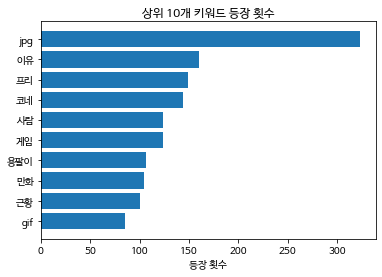

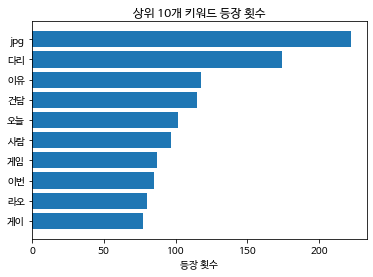

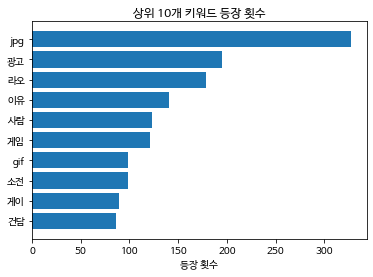

In [12]:
for crawl_page in crawl_pages:
  crawl_min, crawl_max=crawl_page

  # File names, directories
  file_id=("%s %s~%s")%(c_time,crawl_min,(crawl_max-1))

  title_file_name=("%s title crawl %s.txt")%(board_id, file_id)
  title_file_dir=base_dir+title_file_name

  article_file_name=("%s article crawl %s.txt")%(board_id, file_id)
  article_file_dir=base_dir+article_file_name

  bbs_file_name=("%s bbs crawl %s.txt")%(board_id, file_id)
  bbs_file_dir=base_dir+bbs_file_name

  # str type value for save all crawled materials
  wordseed=""

  if crawl_title==True:
    title_crawl_txt=open(title_file_dir,'r')
    wordseed+=title_crawl_txt.read()
    title_crawl_txt.close()

  if crawl_article==True:
    article_crawl_txt=open(article_file_dir,'r')
    wordseed+=article_crawl_txt.read()
    article_crawl_txt.close()

  wordseed=wordseed.replace('\n',' ').replace('\u3000',' ')

  # Delete Emoji
  wordseed=emoji.get_emoji_regexp().sub(u'',wordseed)

  tagged_words=konlpy.tag.Komoran(userdic=base_dir+user_dic_name).pos(wordseed)
  grammar="""
  NP: {<N.*>*<Suffix>?}   # Noun phrase
  VP: {<V.*>*}            # Verb phrase
  AP: {<A.*>*}            # Adjective phrase
  """
  parser=nltk.RegexpParser(grammar)


  if draw_legend==True:
    legend_morp=[]
    legend_count=[]
    wc_words=""
    for morpheme in tagged_words:
      if morpheme[1] in show_tags:
        wc_words+=("%s "%morpheme[0])
        if morpheme[0].isdigit()==False and len(morpheme[0])>1:
          if morpheme[0] in legend_morp:
            legend_count[legend_morp.index(morpheme[0])]+=1
          else:
            legend_morp.append(morpheme[0])
            legend_count.append(1)

  else:
    wc_words=""
    for morpheme in tagged_words:
      if morpheme[1] in show_tags:
        wc_words+=("%s "%morpheme[0]) 

  # Word cloud generate (Komoran+user_dic)
  icon=Image.open(img_dir)
  mask=Image.new("RGB",icon.size, (255,255,255))
  mask.paste(icon,icon)
  mask=np.array(mask)

  wc=WordCloud(font_path=fontpath, background_color="white",max_words=200,mask=mask,max_font_size=500,random_state=1234567)

  wc.generate_from_text(wc_words)
  wc.recolor(color_func=color_func, random_state=1234567)
  wc.to_file(base_dir+("%s Word Cloud %s.png")%(board_id,file_id))


  if draw_legend==True:
    plt_kw=[]
    plt_ct=[]
    for n in range (ranked_keyword):
      index=legend_count.index(max(legend_count))
      plt_kw.append(legend_morp.pop(index))
      plt_ct.append(legend_count.pop(index))
    plt_kw.reverse()
    plt_ct.reverse()
    plt.barh(plt_kw,plt_ct)
    plt.title("상위 %s개 키워드 등장 횟수"%(ranked_keyword))
    plt.xlabel("등장 횟수")
    plt.savefig(base_dir+("%s WC legend %s.png"%(board_id,file_id)))
    plt.show()